In [2]:
import sys
import csv
import math
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path to find data_handling
sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader

DATA_DIR = Path("measurements")
print(f"Data directory: {DATA_DIR.resolve()}")

Data directory: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_merge/xxz_small/measurements


In [3]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim

        # Simple MLP to map delta -> bias shifts
        self.net = nn.Sequential(
            nn.Linear(cond_dim, hidden_width),
            nn.Tanh(),
            nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        )

    def forward(self, cond: torch.Tensor):
        # Expect cond shape (B, cond_dim)
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)

        x = self.net(cond)

        # Split output into scaling (gamma) and shifting (beta) factors
        # for visible (b) and hidden (c) biases
        N, H = self.num_visible, self.num_hidden
        gamma_b, beta_b, gamma_c, beta_c = torch.split(x, [N, N, H, H], dim=-1)
        return gamma_b, beta_b, gamma_c, beta_c

In [4]:
class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim
        self.k = k
        self.T = T

        # Base parameters (shared across all deltas)
        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        nn.init.normal_(self.W, mean=0.0, std=0.01)

        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

    def _normalize_cond(self, cond: torch.Tensor) -> torch.Tensor:
        """
        Normalize input delta [0.4, 2.0] to range ~[-1, 1].
        Center ~ 1.2, Scale ~ 0.8.
        This stabilizes the conditioner network.
        """
        return (cond - 1.2) / 0.8

    def _get_conditional_biases(self, cond: torch.Tensor):
        cond_norm = self._normalize_cond(cond)
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond_norm)

        # Apply modulation: b_mod = b * (1 + gamma) + beta
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    @staticmethod
    def _free_energy(v: torch.Tensor, W: torch.Tensor, b: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        # F(v) = -b.v - sum_h log(1 + exp(W.v + c))
        # b, c are (B, N) and (B, H) here
        if b.dim() == 1: b = b.unsqueeze(0)
        if c.dim() == 1: c = c.unsqueeze(0)

        # Linear term
        term1 = -(v * b).sum(dim=-1)

        # Hidden term
        h_arg = v @ W # (B, H)
        term2 = -F.softplus(h_arg + c).sum(dim=-1)

        return term1 + term2

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, gen: torch.Generator):
        # Sample h | v
        logits_h = (v @ self.W + c_mod) / self.T
        p_h = torch.sigmoid(logits_h)
        h = torch.bernoulli(p_h, generator=gen)

        # Sample v | h
        logits_v = (h @ self.W.t() + b_mod) / self.T
        p_v = torch.sigmoid(logits_v)
        v = torch.bernoulli(p_v, generator=gen)
        return v

    def forward(self, batch, aux_vars):
        """
        Returns contrastive divergence loss + stats
        """
        values, _, cond = batch
        gen = aux_vars.get("gen")
        l2_cond = aux_vars.get("l2_strength", 0.0)

        v_data = values.float()
        cond = cond.to(v_data.device, dtype=v_data.dtype)

        # 1. Get conditional biases
        b_mod, c_mod = self._get_conditional_biases(cond)

        # 2. Regularization on conditioner (keep it close to base biases)
        reg_loss = (self.b.unsqueeze(0) - b_mod).pow(2).sum() + \
                   (self.c.unsqueeze(0) - c_mod).pow(2).sum()

        # 3. CD-k: Run Gibbs chain starting from noise (or data for standard CD)
        # We use noise-start (Persistent CD style without buffer, or just pure generated)
        # But for standard training on data, CD usually starts at v_data.
        # Let's use v_data start for standard Contrastive Divergence.
        # If you want to learn generative model from scratch, noise start is harder.
        # Let's try CD-k (start at data) which is standard for RBMs.
        v_model = v_data.clone()
        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, gen)

        v_model = v_model.detach() # Stop gradient through sampling

        # 4. Free Energy Difference
        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)

        loss = (fe_data - fe_model).mean() + l2_cond * reg_loss

        return loss, {"fe_mean": (fe_data - fe_model).mean().detach()}

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, n_steps: int, gen: torch.Generator):
        cond = cond.to(self.W.device, dtype=torch.float32)
        B = cond.shape[0]

        b_mod, c_mod = self._get_conditional_biases(cond)

        # Start from random noise
        v = (torch.rand((B, self.num_visible), generator=gen, device=self.W.device) < 0.5).float()

        for _ in range(n_steps):
            v = self._gibbs_step(v, b_mod, c_mod, gen)

        return v

In [5]:
def get_sigmoid_schedule(high, low, steps, falloff=0.0005):
    def schedule(step):
        s = min(step, steps)
        # Sigmoid decay
        return low + (high - low) / (1.0 + math.exp(falloff * (s - steps/2)))
    return schedule

def train_step(model, optimizer, batch, aux_vars):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.item(), aux

def train_loop(model, optimizer, loader, num_epochs, gen, l2_cond, lr_fn):
    global_step = 0
    total_steps = num_epochs * len(loader)

    print(f"Start training: {num_epochs} epochs, {len(loader)} batches/epoch")

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        last_fe = 0.0

        for batch in loader:
            # Update LR
            lr = lr_fn(global_step)
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux = {"gen": gen, "l2_strength": l2_cond}
            loss_val, stats = train_step(model, optimizer, batch, aux)

            epoch_loss += loss_val
            last_fe = stats["fe_mean"]
            global_step += 1

        print(f"Epoch {epoch+1:02d}/{num_epochs} | "
              f"Loss: {epoch_loss/len(loader):.4f} | "
              f"FE diff: {last_fe:.4f} | "
              f"LR: {lr:.5f}")

    return model

In [6]:
file_names = [
    "xxz_2x2_delta0.40_100000.npz", "xxz_2x2_delta0.60_100000.npz",
    "xxz_2x2_delta0.80_100000.npz", "xxz_2x2_delta0.90_100000.npz",
    "xxz_2x2_delta0.95_100000.npz", "xxz_2x2_delta1.00_100000.npz",
    "xxz_2x2_delta1.05_100000.npz", "xxz_2x2_delta1.10_100000.npz",
    "xxz_2x2_delta1.40_100000.npz", "xxz_2x2_delta2.00_100000.npz",
]
file_paths = [DATA_DIR / fn for fn in file_names]

# Load dataset
# Using 100k samples per file
ds = MeasurementDataset(
    file_paths,
    load_fn=load_measurements_npz,
    system_param_keys=["delta"],
    samples_per_file=[100_000] * len(file_names)
)

print(f"Dataset loaded: {ds.values.shape} samples, {ds.num_qubits} qubits.")
print("Unique deltas:", torch.unique(ds.system_params).tolist())

Dataset loaded: torch.Size([1000000, 4]) samples, 4 qubits.
Unique deltas: [0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.8999999761581421, 0.949999988079071, 1.0, 1.0499999523162842, 1.100000023841858, 1.399999976158142, 2.0]


In [7]:
# --- HYPERPARAMETERS ---
batch_size = 2048
num_visible = ds.num_qubits
num_hidden = 32
conditioner_width = 64
k_steps = 5              # Reduced from 50 to 5 for stability/speed (standard for RBMs)
num_epochs = 50

init_lr = 1e-2
final_lr = 1e-4

# We want Weight Decay on W (to smooth energy landscape),
# but NOT on biases or conditioner (to allow learning).
weight_decay_W = 2e-4    # Slightly stronger decay on W only

l2_cond_strength = 0.0

# Setup
gen = torch.Generator().manual_seed(42)
loader = MeasurementLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True, gen=gen)

model = ConditionalRBM(
    num_visible=num_visible,
    num_hidden=num_hidden,
    cond_dim=1,
    conditioner_width=conditioner_width,
    k=k_steps,
    T=1.0
)

# --- CRITICAL FIX: PARAMETER GROUPS ---
# We split parameters into those that need decay (W) and those that don't (biases, conditioner)
decay_params = []
nodecay_params = []

for name, param in model.named_parameters():
    if "W" in name:
        decay_params.append(param)
        print(f"Applying weight decay to: {name}")
    else:
        nodecay_params.append(param)

optimizer = torch.optim.Adam([
    {'params': decay_params, 'weight_decay': weight_decay_W},
    {'params': nodecay_params, 'weight_decay': 0.0}
], lr=init_lr)

# Schedule
total_steps = num_epochs * len(loader)
lr_fn = get_sigmoid_schedule(init_lr, final_lr, total_steps)

# Train
model = train_loop(model, optimizer, loader, num_epochs, gen, l2_cond_strength, lr_fn)

Applying weight decay to: W
Start training: 50 epochs, 488 batches/epoch
Epoch 01/50 | Loss: -0.0351 | FE diff: -0.0481 | LR: 0.00997
Epoch 02/50 | Loss: -0.1669 | FE diff: -0.1406 | LR: 0.00996
Epoch 03/50 | Loss: -0.0869 | FE diff: -0.0502 | LR: 0.00995
Epoch 04/50 | Loss: -0.0578 | FE diff: -0.0558 | LR: 0.00994
Epoch 05/50 | Loss: -0.0503 | FE diff: -0.0624 | LR: 0.00993
Epoch 06/50 | Loss: -0.0478 | FE diff: -0.0417 | LR: 0.00990
Epoch 07/50 | Loss: -0.0470 | FE diff: -0.0423 | LR: 0.00988
Epoch 08/50 | Loss: -0.0461 | FE diff: -0.0395 | LR: 0.00985
Epoch 09/50 | Loss: -0.0455 | FE diff: -0.0499 | LR: 0.00980
Epoch 10/50 | Loss: -0.0450 | FE diff: -0.0699 | LR: 0.00975
Epoch 11/50 | Loss: -0.0446 | FE diff: -0.0487 | LR: 0.00969
Epoch 12/50 | Loss: -0.0443 | FE diff: -0.0337 | LR: 0.00960
Epoch 13/50 | Loss: -0.0438 | FE diff: -0.0535 | LR: 0.00950
Epoch 14/50 | Loss: -0.0439 | FE diff: -0.0249 | LR: 0.00937
Epoch 15/50 | Loss: -0.0439 | FE diff: -0.0503 | LR: 0.00921
Epoch 16/50 

In [8]:
def main_diagonal_pairs_linear(L: int) -> List[Tuple[int, int]]:
    # (0,0)->(1,1), etc for L*L grid
    pairs = []
    for x in range(L):
        i = x * (L + 1)
        j = ((x + 1) % L) * (L + 1)
        pairs.append((i, j))
    return pairs

@torch.no_grad()
def compute_observables(model, samples, cond, corr_pairs):
    """
    samples: (B, N) {0,1}
    cond: (B, 1)
    """
    samples = samples.float()
    B = samples.shape[0]

    # --- C_zz ---
    spins = 1.0 - 2.0 * samples
    zz_vals = []
    for i, j in corr_pairs:
        zz_vals.append(spins[:, i] * spins[:, j])
    zz_mean = torch.stack(zz_vals).mean() # Average over pairs and batch

    # --- C_xx (Off-diagonal estimator) ---
    # O_L = sqrt( P(flip) / P(orig) ) = exp( 0.5 * (F(orig) - F(flip)) )

    # Get biases for this batch
    cond = cond.to(model.W.device)
    b_mod, c_mod = model._get_conditional_biases(cond)

    F_orig = model._free_energy(samples, model.W, b_mod, c_mod)

    xx_ratios = []
    for i, j in corr_pairs:
        # Flip bits i and j
        s_flip = samples.clone()
        s_flip[:, i] = 1.0 - s_flip[:, i]
        s_flip[:, j] = 1.0 - s_flip[:, j]

        F_flip = model._free_energy(s_flip, model.W, b_mod, c_mod)

        # Ratio
        # If Weight Decay is missing, F_orig - F_flip can be ~100, exp(50) -> Inf
        ratio = torch.exp(0.5 * (F_orig - F_flip))
        xx_ratios.append(ratio)

    xx_mean = torch.stack(xx_ratios).mean()

    return float(zz_mean), float(xx_mean)

Evaluating pairs: [(0, 3), (3, 0)]
Delta  | Type     | Czz        | Cxx       
---------------------------------------------
0.40   | support  | +0.277500   | +0.367562
0.50   | novel    | +0.274300   | +0.367670
0.60   | support  | +0.292000   | +0.359778
0.70   | novel    | +0.279200   | +0.365342
0.80   | support  | +0.289300   | +0.361333
0.85   | novel    | +0.276900   | +0.367357
0.90   | support  | +0.274300   | +0.369313
0.92   | novel    | +0.268900   | +0.371244
0.95   | support  | +0.264600   | +0.373224
0.98   | novel    | +0.258800   | +0.376552
1.00   | support  | +0.259400   | +0.376224
1.02   | novel    | +0.249800   | +0.379828
1.05   | support  | +0.251000   | +0.380171
1.08   | novel    | +0.250200   | +0.379425
1.10   | support  | +0.263700   | +0.372783
1.20   | novel    | +0.248900   | +0.380815
1.40   | support  | +0.225500   | +0.391919
1.60   | novel    | +0.221800   | +0.394637
1.80   | novel    | +0.190600   | +0.409952
2.00   | support  | +0.192700   | +0.41

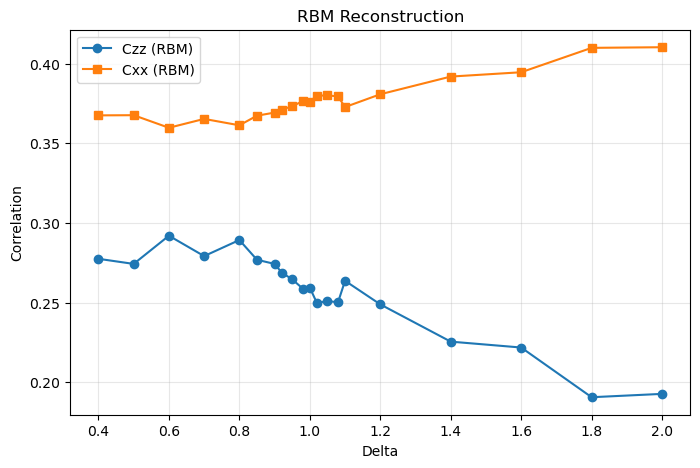

In [9]:
# Define sweep
delta_support = [0.40, 0.60, 0.80, 0.90, 0.95, 1.00, 1.05, 1.10, 1.40, 2.00]
delta_novel   = [0.50, 0.70, 0.85, 0.92, 0.98, 1.02, 1.08, 1.20, 1.60, 1.80]
sweep_deltas = sorted(delta_support + delta_novel)

# Setup evaluation
L = int(math.isqrt(model.num_visible))
pairs = main_diagonal_pairs_linear(L)
print(f"Evaluating pairs: {pairs}")

results = []
n_samples = 20_000
gen_eval = torch.Generator().manual_seed(123)

print(f"{'Delta':<6} | {'Type':<8} | {'Czz':<10} | {'Cxx':<10}")
print("-" * 45)

csv_path = Path("xxz_4x4_correlations_rbm_fixed.csv")

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["delta", "type", "czz", "cxx"])

    for d in sweep_deltas:
        d_type = "support" if d in delta_support else "novel"

        # Prepare condition
        cond_t = torch.full((n_samples, 1), float(d))

        # Sample
        # Use enough Gibbs steps to equilibrate from noise
        samples = model.generate(cond_t, n_steps=200, gen=gen_eval)

        # Compute
        czz, cxx = compute_observables(model, samples, cond_t, pairs)

        print(f"{d:<6.2f} | {d_type:<8} | {czz:+.6f}   | {cxx:+.6f}")

        writer.writerow([d, d_type, czz, cxx])
        results.append((d, czz, cxx))

print(f"\nResults saved to {csv_path.resolve()}")

# Quick Plot
ds_res = np.array(results)
plt.figure(figsize=(8, 5))
plt.plot(ds_res[:, 0], ds_res[:, 1], 'o-', label='Czz (RBM)')
plt.plot(ds_res[:, 0], ds_res[:, 2], 's-', label='Cxx (RBM)')
plt.xlabel('Delta')
plt.ylabel('Correlation')
plt.title('RBM Reconstruction')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()